# Monte Carlo and the stellar IMF

In this exercise we're going to work with the [stellar initial mass function](https://en.wikipedia.org/wiki/Initial_mass_function).  One way to represent the stellar mass function is as $\Phi(m) = \frac{dN(m)}{dm}$ - which is to say, the number of stars between mass $m$ and $m + \Delta m$.  Typically, this distribution is normalized such that

$\int_{M_{low}}^{M_{high}} m \Phi(m) dm = 1~M_\odot$

In this project, we're going to be using the [Chabrier IMF](http://adsabs.harvard.edu/abs/2003PASP..115..763C), which looks like this:

$\Phi(m) = $

$\frac{A}{m} e^{-(\log_{10}(m/m_c))^2/2\sigma^2}, m \leq 1~M_\odot$

$B m^{-\alpha}, \mathrm{otherwise}$

With A = 0.8202, B = 0.2289, $m_c = 0.079~M_\odot$, and $\sigma = 0.69~M_\odot$.  These constants are used for our canonical mass limits, $M_{low} = 0.08~M_\odot$ and $M_{high} = 140~M_\odot$.

We are first going to walk through some examples, and then you will write code to answer two questions.

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [50]:
def Phi(m,alpha=1.8):
    '''
    Expression for \Phi(m) = dN/dm, which we will use for integration.
    inputs: mass in solar masses; optionally a slope for the high-mass end of the IMF.
    outputs: dN/dm at the given mass.
    '''
    if m <= 1.0:
        return 0.8202*np.exp(-np.log10(m/0.08)**2/(2*0.69**2))/m
    else:
        return 0.2289*m**(-alpha)
            
def mPhi(m,alpha=2.3):
    '''
    Expression for m*\Phi(m), which is useful for integration.
    Inputs: mass, slope of the high-mass end of the IMF.
    outputs: m*dN/dm at the given mass
    '''
    return m*Phi(m,alpha)


Let's look at our IMF first!  Note that we calculate our array ```mass``` using bins that are logarithmic in mass because the mass function varies so strongly as a function of mass, and we want to get adequate resolution at low masses.

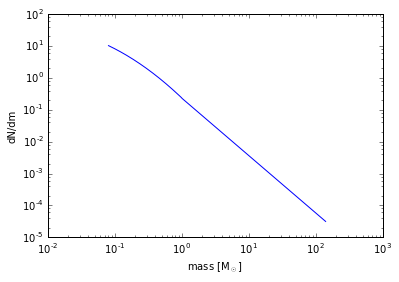

In [51]:
mass = np.logspace(np.log10(0.08),np.log10(140),500)
phi = np.zeros_like(mass)

for i in range(phi.size):
    phi[i] = Phi(mass[i])

plt.plot(mass,phi)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'mass [M$_\odot$]')
plt.ylabel('dN/dm')

Now, we're going to use scipy to perform the integral described above ($m\Phi(m)$) from $M_{low} = 0.08~M_\odot$ and $M_{high} = 140~M_\odot$.  If we've set this up correctly, it'll be pretty close to 1 solar mass.

In [52]:
import scipy.integrate as integrate

total = integrate.quad(mPhi,0.08,140)

print("total integrated value is:",total[0], 'solar masses')

total integrated value is: 0.9999408969517969 solar masses


Now that we have these numbers we can use them to do some useful calculations.  For example, in a star cluster of mass $10^4~M_\odot$, we will have:

$N = 10^4 \int_{M_{low}}^{M_{high}} \Phi(m) dm$

total stars - a calculation that can be adjusted to get the number of stars in any particular mass range.  This type of calculation is done as follows:

In [53]:
cluster_mass = 1.0e+4 # in solar masses
total_stars = cluster_mass * integrate.quad(Phi,0.08,140)[0]

print("there are:", total_stars, "total stars on average in this cluster of mass", cluster_mass, "solar masses")


stars_8_10_msun = cluster_mass * integrate.quad(Phi,50,140)[0]

print("and there are", stars_8_10_msun, "stars between 8 and 10 solar masses")


there are: 17311.010617269043 total stars on average in this cluster of mass 10000.0 solar masses
and there are 70.22504490906364 stars between 8 and 10 solar masses


In [54]:
integrate.quad(Phi,0.08,140)[0]

1.7311010617269045

We can also calculate the fraction of stars that are below a given mass by integrating up to that mass (although we do have to normalize this by the total number of stars).  This can be combined with ```np.interp()``` to calculate the median stellar mass, mass of stars in the 90th percentile (by number), etc.

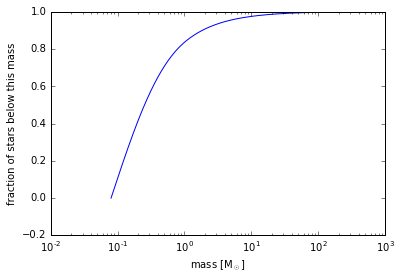

In [55]:
# array of fractional values.
frac = np.zeros_like(mass)

# normalization (total integral of Phi over mass range)
norm = integrate.quad(Phi,0.08,140)[0]

# loop over masses, calculating fraction of stars up to that mass (normalized to 1 at high mass)
for i in range(mass.size):
    frac[i] = integrate.quad(Phi,0.08,mass[i])[0]/norm
    
plt.plot(mass,frac)
#plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'mass [M$_\odot$]')
plt.ylabel('fraction of stars below this mass')

In [56]:
print("the mass of a 10th percentile star is:", np.interp(0.1,frac,mass), "solar masses")
print("the mass of a 50th percentile star is:", np.interp(0.5,frac,mass), "solar masses")
print("the mass of a 90th percentile star is:", np.interp(0.9,frac,mass), "solar masses")
print("the mass of a 99th percentile star is:", np.interp(0.99,frac,mass), "solar masses")
print("the mass of a 99.9th percentile star is:", np.interp(0.999,frac,mass), "solar masses")

the mass of a 10th percentile star is: 0.09886198996155578 solar masses
the mass of a 50th percentile star is: 0.252102478140127 solar masses
the mass of a 90th percentile star is: 1.802396840282501 solar masses
the mass of a 99th percentile star is: 23.61750516361242 solar masses
the mass of a 99.9th percentile star is: 99.39652804491456 solar masses


Given an IMF, one can also construct a discrete set of stars rather than integrated numbers.  For example, if we have a star cluster of mass $\simeq 1000~M_\odot$, we can calculate a discrete stellar population in the manner shown below.

total cluster mass is 3029.55490021 solar masses with 2437 total stars
there are 238 with a mass of at least 2.0 solar masses
*** 238


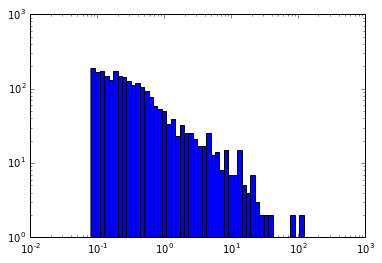

In [57]:
# desired mass of cluster (in solar masses)
mdesired = 3.0e+3

# list of masses
massdist = []
mtotal = 0.0

# HOMEWORK HACK
massive_stars = []
mass_threshold = 2.0


'''Until we reach the desired total'''
while mtotal < mdesired:
    this_mass = np.interp(np.random.rand(),frac,mass)
    massdist.append(this_mass)
    
    if this_mass >= mass_threshold:
        massive_stars.append(this_mass)
    
    mtotal += this_mass

plt.hist(massdist,bins=np.logspace(np.log10(0.08),np.log10(140),50),log=True)
plt.xscale('log')

massdist = np.array(massdist)

total_cluster_mass = massdist.sum()

print("total cluster mass is", total_cluster_mass, "solar masses with", massdist.size, "total stars")

num_massive_stars = massdist[massdist >= mass_threshold].size
print('there are', num_massive_stars, 'with a mass of at least',mass_threshold,'solar masses')
print('***',len(massive_stars))

np.savetxt('IMF_2.dat',np.c_[massive_stars],fmt="%.4f",header="Mass [Msun]")

## Project \#1

Imagine that you observe newly-formed star clusters in the Milky Way and neighboring galaxies, each of which has a total stellar mass of $\simeq 1,000~M_\odot$.  Your goal is to determine whether the stellar initial mass function is universal (i.e., the Chabrier IMF shown above), or whether it varies from galaxy to galaxy.  (See [Bastian et al. 2010](http://adsabs.harvard.edu/abs/2010ARA%26A..48..339B) for a discussion of the universality of the IMF.)

It is relatively easy to observe distant massive stars - say, those that are more massive than 8 $M_\odot$.  However, you need to model the stellar populations in these clusters to get a sense of what the potential variation in numbers of  massive stars are from cluster to cluster so that you can decide what a reasonable range of massive stars might be.

In the cell below (and adding additional cells as necessary), adapt the code above to create a distribution of the number of stars in each cluster that are $\geq 8~M_\odot$, and calculate the range of stars corresponding to 1 and 2 standard deviations ($\simeq 68\%$ and $95\%$ of the total range, respectively).

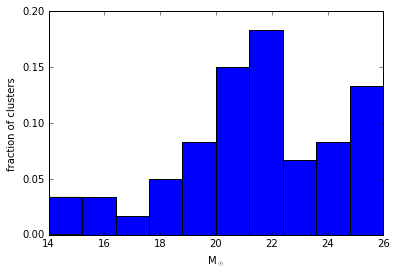

In [58]:
# desired mass of cluster (in solar masses)
mdesired = 1.0e+3

Ncluster = 50

Ngt8 = []

N=0

while N < Ncluster:

    # list of masses
    massdist = []
    mtotal = 0.0

    '''Until we reach the desired total'''
    while mtotal < mdesired:
        this_mass = np.interp(np.random.rand(),frac,mass)
        massdist.append(this_mass)
        mtotal += this_mass

    massdist = np.array(massdist)

    total_cluster_mass = massdist.sum()

    #print("total cluster mass is", total_cluster_mass, "solar masses with", massdist.size, "total stars")

    num_massive_stars = massdist[massdist >= 8.0].size
    #print('there are', num_massive_stars, 'with a mass of at least 8 solar masses')

    Ngt8.append(num_massive_stars)
    
    N+= 1
    
plt.hist(Ngt8,normed=True)
plt.xlabel(r'M$_\odot$')
plt.ylabel('fraction of clusters')

## Project \#2

Now we'll take into consideration even more information in our modeling - the uncertainty in our local observations of the stellar IMF.  As compiled by [Côté et al. 2016](http://adsabs.harvard.edu/abs/2016ApJ...824...82C), the properties of the IMF itself is somewhat uncertain.  Assuming Gaussian errors, the variation in the lower mass cutoff, upper mass cutoff, and slope of the IMF are (from Table 7 of Côté et al.):

$M_{low} = (8.0 \pm 0.62) \times 10^{-2}~M_\odot$

$M_{high} = 138 \pm 36~M_\odot$

$\alpha = 2.29 \pm 0.20$

Assuming that these errors are independent of each other, calculate a more accurate version of the number of stars in each cluster that are $\geq 8~M_\odot$, and calculate the range of stars corresponding to 1 and 2 standard deviations ($\simeq 68\%$ and $95\%$ of the total range, respectively).

**Hint 1:** Use the numpy ```random.normal()``` method to estimate the various quantities that have uncertainty.

**Hint 2:** Will you need to re-normalize anything?  If so, what?

#### put your code here!


